# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [7]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

<br></br>

# Configuration

In [8]:
class CFG:
    TARGET = ['MLM','HLM']
    SEGMENT = None
    SUBSET_DEPTH = 2
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [9]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [10]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# Define the Data Preprocessing

In [11]:
from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, TruncatedSVD

In [12]:
# Molecule to MorganFingerprint
def mol2fp(mol,radius,nBits):
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [13]:
def DataPrepare(train,test,params):
    train_data, test_data = train.copy(), test.copy()
    
    # X변수 log변환
    for col in ['Molecular_Weight','Molecular_PolarSurfaceArea']:
        train_data[col] = np.log(train_data[col])
        test_data [col] = np.log(test_data [col])
        
    # 화학구조 이미지 생성
    PandasTools.AddMoleculeColumnToFrame(train_data,'SMILES','Molecule')
    PandasTools.AddMoleculeColumnToFrame(test_data ,'SMILES','Molecule')
    
    # FPs column 추가
    train_data["FPs"] = train_data.Molecule.apply(lambda m: mol2fp(m,params['radius'],params['nBits']))
    test_data ["FPs"] = test_data .Molecule.apply(lambda m: mol2fp(m,params['radius'],params['nBits']))
    
    # fps -> feature selection by variance
    feature_select = VarianceThreshold(threshold=params['variance_threshold'])
    tr_fps_selected = feature_select.fit_transform(np.stack(train_data['FPs']))
    te_fps_selected = feature_select.transform(np.stack(test_data['FPs']))

    fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]
    train_data = pd.concat([train_data.drop('FPs',axis=1),pd.DataFrame(tr_fps_selected,columns=fps_names)],axis=1)
    test_data  = pd.concat([test_data .drop('FPs',axis=1),pd.DataFrame(te_fps_selected,columns=fps_names)],axis=1)
    
    # 사용할 column만 추출
    unuse_features = ['id','SMILES','Molecule']
    num_features = [col for col in train_data.columns if col not in unuse_features+CFG.TARGET]

    train_data.drop(unuse_features,axis=1,inplace=True)
    test_data .drop(unuse_features,axis=1,inplace=True)
    
    # Imputation
    tr_null_loc = train_data.AlogP.isnull()
    te_null_loc = test_data .AlogP.isnull()

    train_data.AlogP[tr_null_loc] = train_data.LogD[tr_null_loc]
    test_data .AlogP[te_null_loc] = test_data .LogD[te_null_loc]

    # Categorical Taget Quantile
    if params['target_quantile_by_cat']:
        cat_features = ['Num_H_Acceptors','Num_H_Donors']
        for target in CFG.TARGET:
            calculator = CategoricalQuantileCalculator()
            calculator.fit(
                data=train_data,
                test_data=test_data,
                target_feature=target,
                cat_features=cat_features,
                subset_depth=CFG.SUBSET_DEPTH,
                verbose=False,
            )
            train_data = calculator.transform(train_data,prefix=f'{target}_')
            test_data  = calculator.transform(test_data ,prefix=f'{target}_')
        
    # Target Transformation : ['identity','log','sqrt','pca']
    if params['target_transform']=='pca':
        pca_target = TruncatedSVD(n_components=len(CFG.TARGET), random_state=CFG.SEED)
        train_targets = train_data[CFG.TARGET]
        train_targets = pca_target.fit_transform(train_targets)
        train_data[CFG.TARGET] = train_targets
        inverse_transform = pca_target.inverse_transform
    else:
        target_transform = TargetTransform(func=params['target_transform'])
        train_data[CFG.TARGET] = target_transform.fit_transform(train_data[CFG.TARGET])
        inverse_transform = target_transform.inverse_transform
        
    # Reduce Memory
    train_data, _ = reduce_mem_usage(train_data,verbose=False)
    test_data , _ = reduce_mem_usage(test_data ,verbose=False)
    
    # Modeling Dataset
    X      = train_data.drop(CFG.TARGET,axis=1)
    X_test = test_data.copy()

    y = train_data[CFG.TARGET]

    # unique인 컬럼 제외
    unique_info = X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        X = X.drop(unique_cols,axis=1)
        #print('deleted:',len(unique_cols))
    
    if params['use_cat_features']:
        cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
        X     [cat_features] = X     [cat_features].astype(str)
        X_test[cat_features] = X_test[cat_features].astype(str)
    else:
        cat_features = []
    
    return X, y, X_test, cat_features, inverse_transform

<br></br>

# Model Define

In [14]:
def multi_rmse(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse_list = []
    for i in range(y_true.shape[1]):
        rmse = mean_squared_error(y_true=y_true[:,i],y_pred=y_pred[:,i])**0.5
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [15]:
# https://stackoverflow.com/questions/66785587/how-do-i-use-validation-sets-on-multioutputregressor-for-xgbregressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.multioutput import MultiOutputRegressor

from sklearn.utils.validation import _check_fit_params
from sklearn.base import is_classifier
from sklearn.utils.fixes import delayed
from joblib import Parallel
from sklearn.multioutput import _fit_estimator

class Evalset_MultiOutputRegressor(MultiOutputRegressor):
    
    def fit(self, X, y, sample_weight=None, **fit_params):
        """ Fit the model to data.
        Fit a separate model for each output variable.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data.
        y : {array-like, sparse matrix} of shape (n_samples, n_outputs)
            Multi-output targets. An indicator matrix turns on multilabel
            estimation.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Only supported if the underlying regressor supports sample
            weights.
        **fit_params : dict of string -> object
            Parameters passed to the ``estimator.fit`` method of each step.
            .. versionadded:: 0.23
        Returns
        -------
        self : object
        """

        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement"
                             " a fit method")

        X, y = self._validate_data(X, y,
                                   force_all_finite=False,
                                   multi_output=True, accept_sparse=True)

        if is_classifier(self):
            check_classification_targets(y)

        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for "
                             "multi-output regression but has only one.")

        if (sample_weight is not None and
                not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support"
                             " sample weights.")

        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_test, Y_test)] = fit_params_validated.pop('eval_set')
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_estimator)(
                self.estimator, X, y[:, i], sample_weight,
                **fit_params_validated, eval_set=[(X_test, Y_test[:, i])]) #.iloc로 수정
            for i in range(y.shape[1]))
        return self

In [16]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()
    
    def _get_regressors(self):
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'reg:squarederror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
    
        params_lightgbm = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations']//10,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 5,
        }
        
        self.regressors = [
            #MultiOutputRegressor(LinearRegression()),
            #MultiOutputRegressor(RidgeCV(**params_ridge)),
            #MultiOutputRegressor(LassoCV(**params_lasso)),
            MultiOutputRegressor(ElasticNetCV(**params_elasticnet)),
            Evalset_MultiOutputRegressor(XGBRegressor(**params_xgboost)),
            Evalset_MultiOutputRegressor(LGBMRegressor(**params_lightgbm)),
            MultiOutputRegressor(ExtraTreesRegressor(**params_extratrees)),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
        ]
        self.regressors_name = [
            #'OLS',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            'XGBoost',
            'LightGBM',
            'ExtraTrees',
            'CatBoost1',
            'CatBoost2',
            'CatBoost3',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _set_0to100(self,pred):
        pred = np.array(pred).flatten()
        if np.where((pred<0)|(pred>100),1,0).sum()>0:
            pred = [0 if x<0 else
                    100 if x>100 else
                    x for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _rescale_0to100(self,pred,minmax=None):
        pred = np.array(pred)
        
        if minmax is None:
            _min = pred.min(axis=0)
            _max = pred.max(axis=0)
        else:
            _min, _max = minmax
        
        pred = (pred - _min) / (_max-_min)
        pred = 100*pred
        
        return pred, (_min,_max)
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        self.features = X.columns
        self.oh_features = X_oh.columns

        tr_true = np.array(y)
        va_true = np.array(y_val)
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = 0   #min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = 100 #max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.scores = []
        self.weights = []
        self.fitting_elapsed = []
        self.minmax_list = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
                
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=self.hyperparameters['iterations']//50,
                    #verbose=True,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                fit_params = {
                    'eval_set':[(X_val_oh.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_oh.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                fit_params = {
                    'eval_set':[(X_val_tmp.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_tmp.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh.values,y.values)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred)
            va_pred = np.array(va_pred)
            
            #tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            #va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
                
            tr_pred = self._set_0to100(tr_pred)
            va_pred = self._set_0to100(va_pred)
            
#             tr_pred, minmax = self._rescale_0to100(tr_pred,minmax=None)
#             va_pred, _      = self._rescale_0to100(va_pred,minmax=minmax)
            
            # global _tr_pred, _va_pred, _tr_true, _va_true
            # _tr_pred,_va_pred = tr_pred,va_pred
            # _tr_true,_va_true = tr_true,va_true
            
            tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
            tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
            va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
            va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
            tr_score = 0.5*tr_score_1+0.5*tr_score_2
            va_score = 0.5*va_score_1+0.5*va_score_2
            
            e = time.time()
            self.scores.append(va_score)
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            #self.minmax_list.append(minmax)
            self.minmax_list.append([0,100])
            
            if verbose:
                blank = ' '*(11-len(regressor_name))
                fit_iter_str = str(fit_iter).zfill(len(str(len(self.regressors))))
                fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                    .format(fit_iter_str,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
                print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
        tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
        va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
        va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
        ens_tr_score = 0.5*tr_score_1+0.5*tr_score_2
        ens_va_score = 0.5*va_score_1+0.5*va_score_2
        
        if verbose:
            ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
            print(ens_fit_progress)
        
        self.ensemble_score = ens_va_score
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor,minmax in zip(self.regressors_name,self.regressors,self.minmax_list):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            #y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                y_pred = self.inverse_transform(np.array(y_pred))
                y_pred = self._set_inf_to_maximum(y_pred,self.maximum_value)
                
            y_pred = self._set_0to100(y_pred)
            #y_pred, _ = self._rescale_0to100(y_pred,minmax=minmax)
            
            pred_list.append(y_pred)
            
        final_pred = []
        for pred,weight in zip(pred_list,self.weights):
            pred = np.array(pred)*weight
            final_pred.append(pred)
        final_pred = np.sum(final_pred,axis=0)
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'scores' : self.scores,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'ensemble_score' : self.ensemble_score,
            'minmax_list' : self.minmax_list,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.scores = save_dict['scores']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.ensemble_score = save_dict['ensemble_score']
            self.minmax_list = save_dict['minmax_list']

In [17]:
def load_model(hyperparameters,path):
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    ensemble_model.load_model(path)
    return ensemble_model

<br></br>

# Parameter-Search

In [18]:
import datetime
import optuna
import warnings

class KFoldOptuna:
    def __init__(self,train_data,test_data):
        super().__init__()
        self.train_data = train_data
        self.test_data  = test_data

    def fit(self,n_trials):
        self.total_starttime = datetime.datetime.now()
        self.trials = {}
        self.trial_iter = 0
        self.study = optuna.create_study(
            study_name='Regression',
            sampler=optuna.samplers.TPESampler(seed=CFG.SEED),
            direction='minimize',
        )
        
        self.iter_runtime = []
        self.study.optimize(self._objective,n_trials=n_trials)
        self.total_endtime = datetime.datetime.now()
        self.total_runtime = (self.total_endtime-self.total_starttime).seconds
        
    def _objective(self,trial):
        preprocessing_params = {
            'radius' : trial.suggest_categorical('radius',[3,6,12]),
            'nBits' : trial.suggest_categorical('nBits',[256,1024,4096]),
            'variance_threshold' : trial.suggest_categorical('variance_threshold',[0.01,0.05,0.20]),
            'target_transform' : trial.suggest_categorical('target_transform',['identity','log','pca']),
            'target_quantile_by_cat' : trial.suggest_categorical('target_quantile_by_cat',[0,1]),
            'use_cat_features' : trial.suggest_categorical('use_cat_features',[0,1]),
        }
        model_params = {
            'max_depth' : 7,
            'random_state' : 0,
            'learning_rate' : 0.05,
            'iterations' : 20000,
            'early_stopping_rounds' : 300,
        }
        
        # 학습시작시간
        starttime = time.time()
        
        # return 할 trials를 설정
        self.trial_iter += 1 
        self.trials[str(self.trial_iter)] = {
            'preprocessing_params' : preprocessing_params,
            'model_params' : model_params,
        }
        
        # optuna에서는 이미 학습한 parameter임에도 또 수행하는 것 같음
        # -> 이미 학습한 parameter가 있는 경우에는 해당 iteration의 study를 pass함
        check_already_trained = [1 for k,v in self.trials.items()
                                 if (v['preprocessing_params']==preprocessing_params) & (k!=str(self.trial_iter))]
        if sum(check_already_trained)>0:
            warnings.warn('already trained parameters')
            ens_scores = [99999]*CFG.N_SPLITS
            ens_models = [None] *CFG.N_SPLITS
            stk_scores = [99999]*CFG.N_SPLITS
            stk_models = [None] *CFG.N_SPLITS
        else:
            X, y, X_test, cat_f, inv_fn = DataPrepare(
                self.train_data.copy(),
                self.test_data .copy(),
                preprocessing_params,
            )
            ens_models, ens_scores, stk_models, stk_scores = self._kf_train(
                X,y,
                params=model_params,
                cat_features=cat_f,
                inverse_transform=inv_fn,
            )
            ens_scores = ens_scores.multi_rmse.values
            stk_scores = stk_scores.multi_rmse.values
        
        # return 할 trials에 scores, models를 추가
        self.trials[str(self.trial_iter)]['ensemble_models'] = ens_models
        self.trials[str(self.trial_iter)]['ensemble_scores'] = ens_scores
        self.trials[str(self.trial_iter)]['stacking_models'] = stk_models
        self.trials[str(self.trial_iter)]['stacking_scores'] = stk_scores
        
        # 학습종료시간 및 학습시간 append
        endtime = time.time()
        self.iter_runtime.append(endtime-starttime)

        return np.mean(stk_scores)
        
    def _kf_train(self,X,y,params,cat_features,inverse_transform):
        ensemble_save_path = './mc/optuna/ensemble_trial{}_k{}.pickle'
        stacking_save_path = './mc/optuna/stacking_trial{}_k{}.pickle'
        
        kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

        ensemble_models, stacking_models = [],[]
        ensemble_scores, stacking_scores = [],[]
        k=0
        for tr_idx,val_idx in kf.split(X,y):
            k+=1
            gc_collect_all(verbose=False)

            # kfold dataset            
            X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

            # define the model
            ensemble_model = WeightedEnsembleRegressor(
                hyperparameters=params,
                weight='balanced',
                inverse_transform=inverse_transform,
            )
            # cat만 가져오기
            ensemble_model.regressors = ensemble_model.regressors[-3:]
            ensemble_model.regressors_name = ensemble_model.regressors_name[-3:]

            # fit the model
            ensemble_model.fit(
                X_tr,y_tr,
                eval_set=[(X_va,y_va)],
                oh_set=[(X_tr,X_va)],
                cat_features=cat_features,
                verbose=0,
            )

            # save the model
            ensemble_model.save_model(ensemble_save_path.format(self.trial_iter,k))
            tr_pred = ensemble_model.predict(X_tr,X_tr)
            va_pred = ensemble_model.predict(X_va,X_va)

            tr_true = inverse_transform(y_tr)
            va_true = inverse_transform(y_va)
            
            # caculate score
            score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
            score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
            score = 0.5*score_1+0.5*score_2

            # append inner loop
            ensemble_models.append(ensemble_model)
            ensemble_scores.append([k,len(X_tr),len(X_va),score])
            
            # stacking
            X_tr[['pred1','pred2']] = tr_pred
            X_va[['pred1','pred2']] = va_pred

            stacking_model = WeightedEnsembleRegressor(
                hyperparameters=params,
                weight='balanced',
                inverse_transform=inverse_transform,
            )
            # cat만 가져오기
            stacking_model.regressors = ensemble_model.regressors[-3:]
            stacking_model.regressors_name = ensemble_model.regressors_name[-3:]
            
            # fit the model
            stacking_model.fit(
                X_tr,y_tr,
                eval_set=[(X_va,y_va)],
                oh_set=[(X_tr,X_va)],
                cat_features=cat_features,
                verbose=0,
            )

            # save the model
            stacking_model.save_model(stacking_save_path.format(self.trial_iter,k))
            tr_pred = stacking_model.predict(X_tr,X_tr)
            va_pred = stacking_model.predict(X_va,X_va)

            tr_true = inverse_transform(y_tr)
            va_true = inverse_transform(y_va)
            
            # caculate score
            score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
            score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
            score = 0.5*score_1+0.5*score_2

            # append inner loop
            stacking_models.append(stacking_model)
            stacking_scores.append([k,len(X_tr),len(X_va),score])
            
#             # train
#             fig = plt.figure(figsize=(15,7))
#             fig.add_subplot(121)
#             sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
#             abline(0,1)
#             plt.grid()
#             plt.title(CFG.TARGET[0])
#             fig.add_subplot(122)
#             sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
#             abline(0,1)
#             plt.grid()
#             plt.title(CFG.TARGET[1])
#             plt.suptitle('[1] Training dataset',fontsize=20)
#             plt.tight_layout()
#             plt.show()

#             # validation
#             fig = plt.figure(figsize=(15,7))
#             fig.add_subplot(121)
#             sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
#             abline(0,1)
#             plt.grid()
#             plt.title(CFG.TARGET[0])
#             fig.add_subplot(122)
#             sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
#             abline(0,1)
#             plt.grid()
#             plt.title(CFG.TARGET[1])
#             plt.suptitle('[2] Validation dataset',fontsize=20)
#             plt.tight_layout()
#             plt.show()
        
        ensemble_score_df = pd.DataFrame(ensemble_scores,columns=['k','n_train','n_val','multi_rmse'])
        stacking_score_df = pd.DataFrame(stacking_scores,columns=['k','n_train','n_val','multi_rmse'])
        return ensemble_models, ensemble_score_df, stacking_models, stacking_score_df

In [19]:
%%time

tuner = KFoldOptuna(train_df,test_df)
tuner.fit(n_trials=50)

[I 2023-08-23 18:13:07,692] A new study created in memory with name: Regression
[I 2023-08-23 18:15:22,231] Trial 0 finished with value: 39.144033898779035 and parameters: {'radius': 6, 'nBits': 4096, 'variance_threshold': 0.2, 'target_transform': 'log', 'target_quantile_by_cat': 1, 'use_cat_features': 1}. Best is trial 0 with value: 39.144033898779035.
[I 2023-08-23 18:29:12,324] Trial 1 finished with value: 31.530712343840342 and parameters: {'radius': 6, 'nBits': 1024, 'variance_threshold': 0.05, 'target_transform': 'pca', 'target_quantile_by_cat': 0, 'use_cat_features': 1}. Best is trial 1 with value: 31.530712343840342.
[I 2023-08-23 18:32:46,971] Trial 2 finished with value: 39.96153172077942 and parameters: {'radius': 6, 'nBits': 256, 'variance_threshold': 0.01, 'target_transform': 'log', 'target_quantile_by_cat': 1, 'use_cat_features': 0}. Best is trial 1 with value: 31.530712343840342.
[I 2023-08-23 18:34:42,235] Trial 3 finished with value: 39.314448155261715 and parameters: 

CPU times: user 11h 42min 38s, sys: 1h 4min 9s, total: 12h 46min 47s
Wall time: 2h 29min 10s


In [22]:
np.array(tuner.iter_runtime).round(2)

array([134.54, 830.09, 214.64, 115.26,   0.  , 225.74, 648.29, 601.33,
       247.58, 203.87,   0.  , 244.51,   0.  ,   0.  ,   0.  ,   0.  ,
       425.2 ,   0.  , 207.37,   0.  , 266.67,   0.  ,   0.  ,   0.  ,
         0.  , 339.57, 209.54,   0.  , 273.67, 131.04, 227.38,   0.  ,
         0.  ,   0.  ,   0.  , 489.16, 113.28, 241.8 , 497.19, 118.76,
       347.15,   0.  ,   0.  ,   0.  ,   0.  , 168.12,   0.  , 294.73,
       889.31, 243.84])

In [23]:
tuner.total_runtime

8950

In [24]:
tuner.study.best_params

{'radius': 3,
 'nBits': 4096,
 'variance_threshold': 0.05,
 'target_transform': 'pca',
 'target_quantile_by_cat': 1,
 'use_cat_features': 0}

<br></br>

# Inference

In [25]:
# [v.values for v in tuner.study.best_trials]

In [26]:
X, y, X_test, cat_f, inv_fn = DataPrepare(train_df,test_df,tuner.study.best_params)
X_tr, X_va, y_tr, y_va = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=CFG.SEED)

In [27]:
[k for k,v in tuner.trials.items() if v['preprocessing_params']==tuner.study.best_params]

['27', '28']

In [41]:
np.min([np.mean(v['stacking_scores']) for k,v in tuner.trials.items()])

30.823333361242227

In [45]:
np.min([np.mean(v['ensemble_scores']) for k,v in tuner.trials.items()])

30.75360967898788

In [46]:
model_params = tuner.trials['27']['model_params']

# model_params = {
#     'max_depth' : 7,
#     'random_state' : 0,
#     'learning_rate' : 0.05,
#     'iterations' : 2,#20000,
#     'early_stopping_rounds' : 300,
# }

# define the model
ensemble_model = WeightedEnsembleRegressor(
    hyperparameters=model_params,
    weight='balanced',
    inverse_transform=inv_fn,
)
# cat만 가져오기
ensemble_model.regressors = ensemble_model.regressors[-3:]
ensemble_model.regressors_name = ensemble_model.regressors_name[-3:]

# fit the model
ensemble_model.fit(
    X_tr,y_tr,
    eval_set=[(X_va,y_va)],
    oh_set=[(X_tr,X_va)],
    cat_features=cat_f,
    verbose=0,
)

# save the model
# ensemble_model.save_model(save_path.format(self.trial_iter,k))
tr_pred = ensemble_model.predict(X_tr,X_tr)
va_pred = ensemble_model.predict(X_va,X_va)

In [47]:
if inv_fn is not None:
    y_new = inv_fn(y_va)
else:
    y_new = np.array(y_va)

In [48]:
multi_rmse(va_pred,y_new)

31.030808036863732

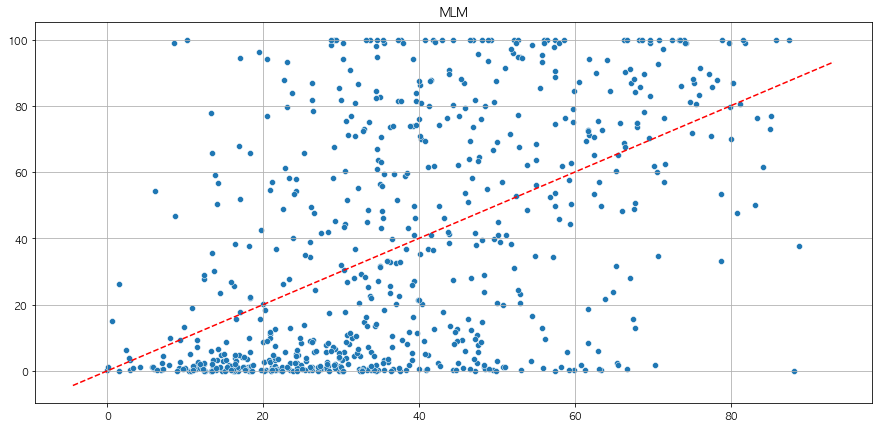

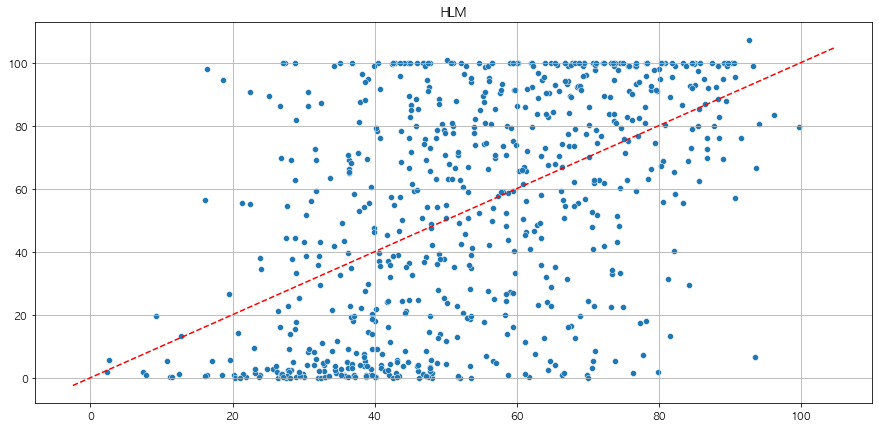

In [49]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=va_pred[:,0],y=y_new[:,0])
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

plt.figure(figsize=(15,7))
sns.scatterplot(x=va_pred[:,1],y=y_new[:,1])
abline(0,1)
plt.grid()
plt.title('HLM')
plt.show()

In [51]:
te_pred = ensemble_model.predict(X_test,X_test)

In [52]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred

In [53]:
submit.tail()

,id,MLM,HLM
478,TEST_478,10.816286,27.820826
479,TEST_479,79.536860,90.675805
480,TEST_480,41.372407,66.480814
481,TEST_481,59.465974,75.935067
482,TEST_482,28.820255,53.678596


In [54]:
submit.min(),submit.max()

(id     TEST_000
 MLM    4.071833
 HLM     5.65365
 dtype: object,
 id      TEST_482
 MLM     97.84566
 HLM    97.692499
 dtype: object)

In [55]:
# public : 28.7199439989 (identity)
submit.to_csv('./out/tmp2.csv',index=False)